In [1]:
import numpy as np
import pandas as pd
import json
import re
import itertools


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import TruncatedSVD


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='white', palette='deep', font_scale=1.5, color_codes=True)

### EDA

Load Data into a pandas dataframe

In [2]:
recipies = pd.read_json("recipies.json")
recipies.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


This is a multilabel, unbalanced classification task

In [3]:
recipies['cuisine'].describe()

count       39774
unique         20
top       italian
freq         7838
Name: cuisine, dtype: object

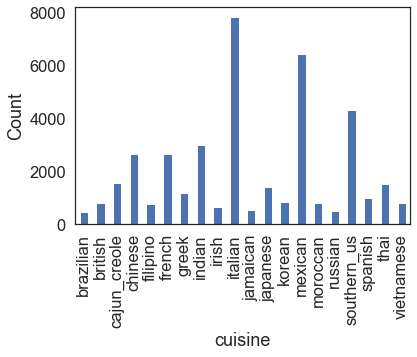

In [4]:
recipies['cuisine'].value_counts().sort_index().plot(kind='bar');
plt.ylabel("Count");
plt.xlabel("cuisine");

There are no missing values

In [5]:
recipies.isnull().mean()

id             0.0
cuisine        0.0
ingredients    0.0
dtype: float64

In [6]:
recipie_lengths = recipies['ingredients'].apply(len)

In [7]:
recipie_lengths.describe()

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: ingredients, dtype: float64

In [8]:
recipies.insert(2, column='num_ingredients', value = recipie_lengths)

In [9]:
recipies.head()

,id,cuisine,num_ingredients,ingredients
0,10259,greek,9,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,11,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,12,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,4,"[water, vegetable oil, wheat, salt]"
4,13162,indian,20,"[black pepper, shallots, cornflour, cayenne pe..."


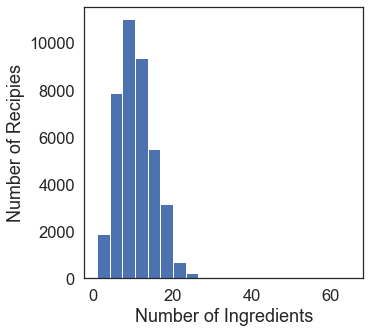

In [10]:
fig = plt.figure(figsize=(5,5))
plt.hist(recipies['num_ingredients'], bins=20)
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipies')
plt.show()

In [11]:
def preprocessor(text):
    text = text.replace('&', '').replace('(', '').replace(')','').replace('\'', '').replace('\\', '')
    
    return text.replace('low-fat ', '').replace('all purpose ', '').replace('plain ', '').replace('ground ', '')

In [12]:
def tokenizer(text):
    return text.split('|')

In [13]:
## Join words to a single line as required by CountVectorizer
recipies['ingredients'] = recipies['ingredients'].apply(lambda x: '|'.join([word for word in x]))
recipies['ingredients'] = recipies['ingredients'].apply(preprocessor)

In [14]:
recipies['ingredients']

0        romaine lettuce|black olives|grape tomatoes|ga...
1        flour|pepper|salt|tomatoes|black pepper|thyme|...
2        eggs|pepper|salt|mayonaise|cooking oil|green c...
3                           water|vegetable oil|wheat|salt
4        black pepper|shallots|cornflour|cayenne pepper...
                               ...                        
39769    light brown sugar|granulated sugar|butter|warm...
39770    KRAFT Zesty Italian Dressing|purple onion|broc...
39771    eggs|citrus fruit|raisins|sourdough starter|fl...
39772    boneless chicken skinless thigh|minced garlic|...
39773    green chile|jalapeno chilies|onions|black pepp...
Name: ingredients, Length: 39774, dtype: object

In [15]:
all_ingredients = [ingredient for ingredients in recipies['ingredients'].apply(lambda x: x.split('|')) for ingredient in ingredients]
VOCAB = sorted(list(set(all_ingredients)))
print("%s unique ingredients total" % (len(VOCAB)))

6613 unique ingredients total


In [16]:
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

X = recipies['ingredients']
y = recipies['cuisine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

## Modeling

In [17]:
pipeline = Pipeline([('vect', CountVectorizer(vocabulary=VOCAB, tokenizer=tokenizer)),
                     ('clf', LogisticRegression(max_iter=1000, C=1, multi_class='multinomial', fit_intercept=True))
])

In [288]:
param_grid ={'clf__C': [0.1, 1, 10]}
gs = GridSearchCV(pipeline, param_grid, cv=3)

In [289]:
gs.fit(X_train, y_train);

In [290]:
gs.best_params_

{'clf__C': 1}

In [18]:
pipeline.fit(X_train, y_train);

In [19]:
print(classification_report(pipeline.predict(X_test), y_test))

              precision    recall  f1-score   support

   brazilian       0.58      0.74      0.65        66
     british       0.43      0.56      0.49       119
cajun_creole       0.68      0.78      0.73       284
     chinese       0.83      0.77      0.80       551
    filipino       0.58      0.68      0.62       117
      french       0.65      0.62      0.63       579
       greek       0.68      0.76      0.72       224
      indian       0.89      0.87      0.88       617
       irish       0.42      0.58      0.49       108
     italian       0.88      0.81      0.84      1719
    jamaican       0.63      0.83      0.71        69
    japanese       0.72      0.80      0.76       254
      korean       0.70      0.85      0.77       138
     mexican       0.93      0.90      0.91      1380
    moroccan       0.76      0.88      0.82       143
     russian       0.47      0.53      0.50        80
 southern_us       0.78      0.69      0.73       951
     spanish       0.49    

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20, rotation=90)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=8)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [24]:
def get_most_important_ingredients(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index, cuisine in enumerate(model.classes_):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[cuisine] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes


In [25]:
def plot_important_words(ingredients, cuisine='italian'):
    
    top_scores = [a[0] for a in importance[cuisine]['tops']]
    top_words = [a[1] for a in importance[cuisine]['tops']]
    bottom_scores = [a[0] for a in importance[cuisine]['bottom']]
    bottom_words = [a[1] for a in importance[cuisine]['bottom']]
    
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Uncommon Ingredients', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Common Ingredients', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(cuisine, fontsize=36)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)

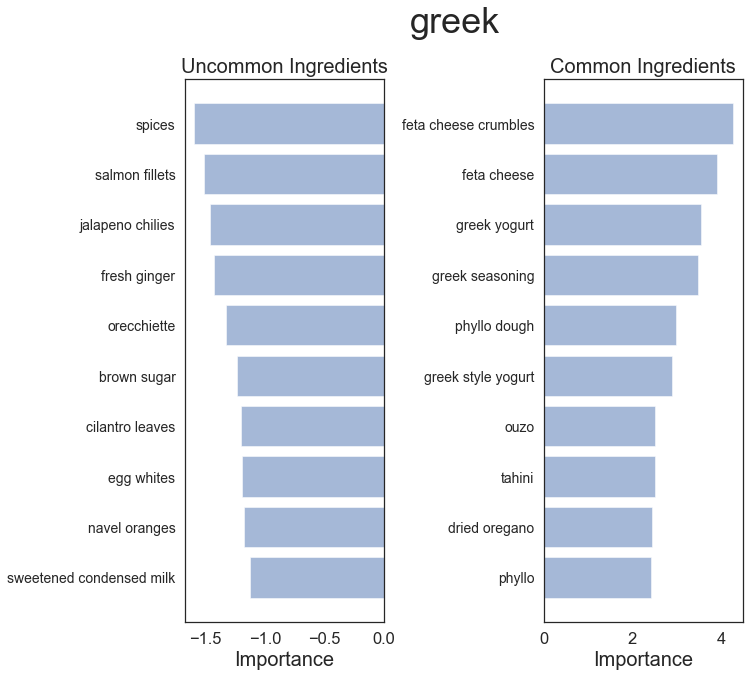

In [26]:
importance = get_most_important_ingredients(pipeline['vect'], pipeline['clf'], 10)
plot_important_words(importance, "greek")

plt.savefig("greek", dpi=300, bbox_inches='tight')

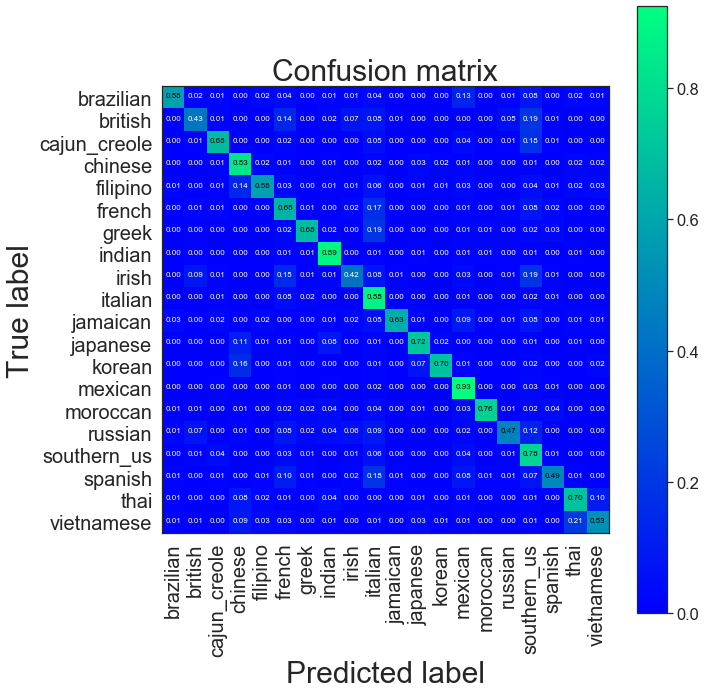

In [28]:
cm = confusion_matrix(y_test, pipeline.predict(X_test))
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes= pipeline.classes_, normalize=True, title='Confusion matrix')

plt.savefig("confusion", dpi=300, bbox_inches='tight')